<img src="causality.jpg" width="300" height="400" align="right"/>

# Time Series Analysis: VAR Models

Author: Christoph Güttner


**Abstract**  
A VAR(1) process is generated, analysed  
(Fourier tranformation, autocorrelation, differenced,   
stationarity, cointegration, Granger causality).   
Daily data of one year (2020) is used to train  
the VAR Model and predict two further months  
(- March 2021). After the residuals are checked,  
forecasts are made and evaluated.

In general, a VAR(p=1) process has the following form:  
    
(1): $z_{t}$ exogenouse Variable  
  
(2): $x_{t}^{{(1)}}=\nu _{1}+a_{{11}}x_{{t-1}}^{{(1)}}+a_{{12}}x_{{t-1}}^{{(2)}}+b_{1}z_{t}+\epsilon _{1}$  
  
(3): $x_{t}^{{(2)}}=\nu _{2}+a_{{21}}x_{{t-1}}^{{(1)}}+a_{{22}}x_{{t-1}}^{{(2)}}+b_{2}z_{t}+\epsilon _{2}$  

In Matrix representation:

 ${\begin{pmatrix}x^{1}_{t}\\x^{2}_{t}\end{pmatrix}}={\begin{pmatrix} \nu_{1}\\\nu_{2}\end{pmatrix}} + {\begin{pmatrix}a_{{11}}&a_{{12}}\\a_{{21}}&a_{{22}}\end{pmatrix}}*{\begin{pmatrix}x^{1}_{t-1}\\x^{2}_{t-1}\end{pmatrix}}+ {\begin{pmatrix}b_{1}\\b_{2}\end{pmatrix}* {\begin{pmatrix}z_{1}\\z_{2}\end{pmatrix}}}+ {\begin{pmatrix}\epsilon _{1}\\\epsilon _{2}\end{pmatrix}}$  
 
 **Results:** The model captures all information   
 that is in the data and makes appropiate forecasts.



## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)

* [VAR Process](#Model_Selection)
    * [Generating VAR(1)](#Generating_VAR(1))

* [Explorative Data Analysis](#Explorative_Data_Analysis)   
    * [Fourier Transformation](#Fourier_Transformation)
    * [(Partial-) Autocorrelation](#Partial_Autocorrelation)
    * [Differencing](#Differencing)
    * [Dickey Fuller Test](#Dickey_Fuller_Test)
    * [Granger Causality Test](#Granger_Causality_Test)

  
* [VAR Model](#VAR_Model)
    * [Train Test Split](#Split)
    * [Model Summary](#Model_Summary)

* [Residual Check](#VAR_Model)
    * [(Partial-) Autocorrelation](#Partial_Autocorrelation)
    * [Durbin Watson Test](#Durbin_Watson_Test)
      
* [Predictions](#Predictions)
* [Evaluation](#Evaluation)

## Class Imports

In [595]:
import numpy as np
import pandas as pd
from scipy import stats

import sympy as sym
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR

In [596]:
def generate_VAR1(p, A, const, sigma, y, n_samples):
    # p = 1
    # B = sym.Matrix([[0.0], [0.0]])
    # C = B
    rv = []
    for t in range(p, n_samples):
        sum = sym.Matrix([[0.0], [0.0]])
        for i in range(1,p+1):
            ynew = A * y
            sum += ynew
            y = ynew
        U = sym.Matrix([[np.random.normal(const, sigma)], [np.random.normal(const, sigma)]])
        rv.append(sum + U)

    return rv

def normalise(data):
    mean=data.mean()
    std = data.std()
    return (data-mean)/ std

def plot_differences(df):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1)
    fig.tight_layout()
    df.plot(figsize=(15,5), color=['#4E7989', '#FD0C81'], ax=ax1)
    ax1.set_title('Original TS')
    df.diff().plot(figsize=(15,5), color=['#4E7989', '#FD0C81'], ax=ax2)
    ax2.set_title('First Difference')
    df.diff().diff().plot(figsize=(15,5), color=['#4E7989', '#FD0C81'], ax=ax3)
    ax3.set_title('Second Difference')
    plt.show()


def dickey_fuller(ts):
    result = adfuller(ts)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

def test_cointegration(ts1, ts2):
    result = coint(ts1, ts2)
    print('t-statistic of unit-root test on residuals: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    list=['1%','5%','10%']
    for i,value in enumerate(result[2]):
        
        print('\t%s: %.3f' % (list[i],value))

    if result[0] < result[2][1]:
        print ("Reject Ho - Time Series are Cointegrated")
    else:
        print ("Failed to Reject Ho - Time Series are Not Cointegrated")


def rolling_forecast_VAR(df,lag_order, train_len, test_len):
    #start = df.iloc[train_len, :].values
    rolling_predictions = []
    for i in range(test_len):
        train = df.iloc[:(train_len-1+i), :]
        model = VAR(train)
        model_fit = model.fit(maxlags=lag_order)                     
        pred = model_fit.forecast(train.values[-lag_order:], steps=1)
        rolling_predictions.append(pred)
    return rolling_predictions

## VAR(1) Process

Here, we generate a simple VAR(1) as follows:

 ${\begin{pmatrix}x^{1}_{t}\\x^{2}_{t}\end{pmatrix}} = {\begin{pmatrix}a_{{11}}&a_{{12}}\\a_{{21}}&a_{{22}}\end{pmatrix}}*{\begin{pmatrix}x^{1}_{t-1}\\x^{2}_{t-1}\end{pmatrix}}+ {\begin{pmatrix}\epsilon _{1}\\\epsilon _{2}\end{pmatrix}}$ 

In [630]:

t1 = sym.symbols('t-1')
t2 = sym.symbols('t-2')
a11, a12, a13, a14  = sym.symbols('a11 a12 a13 a14')
x1 = sym.IndexedBase('x1')
x2 = sym.IndexedBase('x2')
epsilon, epsilon  = sym.symbols('epsilon epsilon')


M1 = sym.Matrix([[a11, a12], [a13, a14]])
M2 = sym.Matrix([x1[t1], x2[t1]])

M3 = sym.Matrix([epsilon, epsilon])


# M1*M2 + M3 *M4 + M5
M1*M2 + M3


Matrix([
[a11*x1[t-1] + a12*x2[t-1] + epsilon],
[a13*x1[t-1] + a14*x2[t-1] + epsilon]])

### More concrete

Our Var(1)process has a parameter matrix with a unit root

$A_{t} = {\begin{pmatrix}a_{{11}}&a_{{12}}\\a_{{21}}&a_{{22}}\end{pmatrix}}= {\begin{pmatrix}1 &0,1 \\-0,1& 1\end{pmatrix}}$

## Data Generating

In [598]:
date_index = pd.date_range(start='1/1/2020', end='3/1/2021')
A1 = sym.Matrix(np.array([[1, 0.1], [-0.1, 1]]))
p = 1
sigma = 0.01
const=0.0

U = sym.Matrix([[np.random.normal(0.0, sigma)], [np.random.normal(0.0, sigma)]])
y = sym.Matrix([[0.7], [-0.7]])


vector_ar = generate_VAR1(p, A1, const, sigma, y, len(date_index))


In [599]:
V1=[]
V2=[]
for i in range(len(vector_ar)):
    V1.append(np.float32(vector_ar[i][0]))
    V2.append(np.float32(vector_ar[i][1]))

dict= {'V1': V1, 'V2':V2}
df=pd.DataFrame(dict, index=date_index[p:])
df.head(2)

,V1,V2
2020-01-02,0.618611,-0.775385
2020-01-03,0.552967,-0.806410




### Normalise 

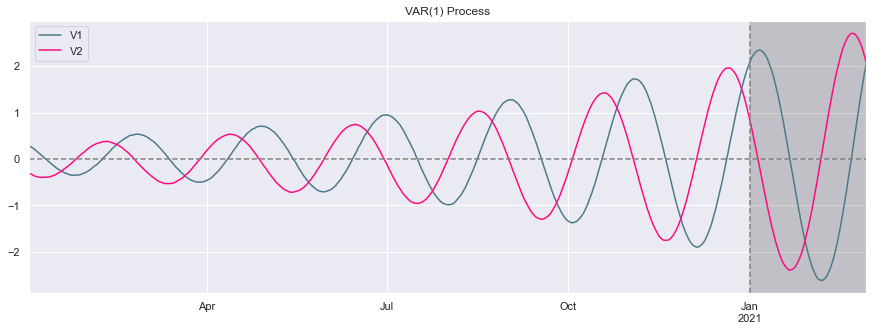

In [600]:
df = normalise(df)

df .plot(figsize=(15,5), color=['#4E7989', '#FD0C81'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('VAR(1) Process')
plt.show()

## Explorative Data Analysis

### Check Frequency

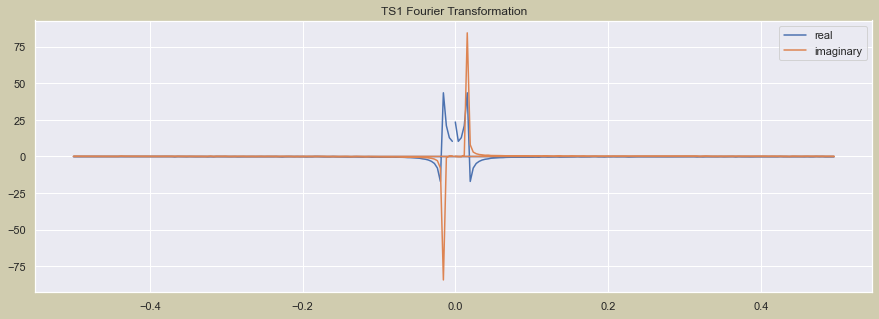

In [601]:
freq = np.fft.fftfreq(df['V1'].index[:256].shape[-1]) #256=2**6
sp = np.fft.fft(df['V1'][:256])

plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(freq, sp.real,label='real')
plt.plot(freq, sp.imag, label='imaginary')
plt.title('TS1 Fourier Transformation')
plt.legend()
plt.show()

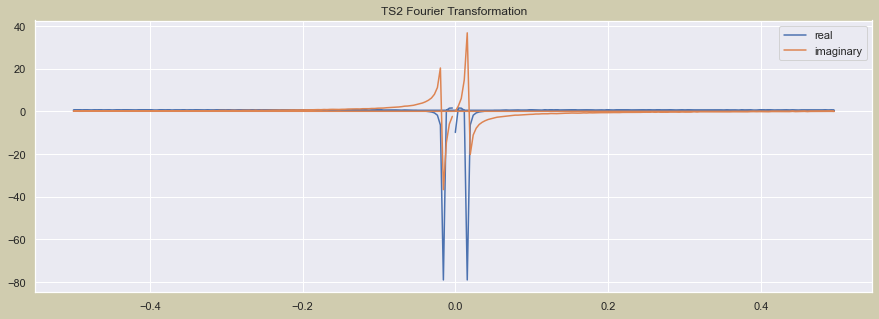

In [602]:
freq = np.fft.fftfreq(df['V2'].index[:256].shape[-1]) #256=2**6
sp = np.fft.fft(df['V2'][:256])

plt.figure(facecolor='#D0CCAF', figsize=(15,5))
plt.plot(freq, sp.real,label='real')
plt.plot(freq, sp.imag, label='imaginary')
plt.title('TS2 Fourier Transformation')
plt.legend()
plt.show()

## Check Partial_Autocorrelation

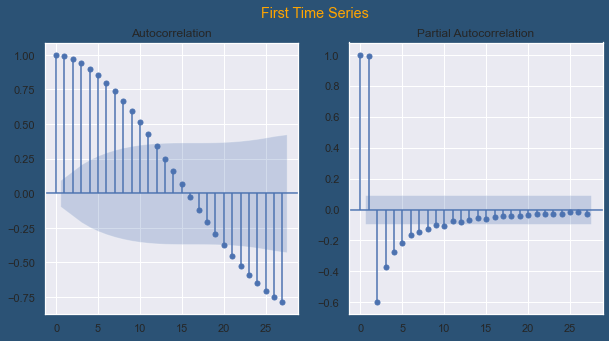

In [603]:
fig = plt.figure(figsize=(10,5),facecolor='#2B5275')
fig.suptitle('First Time Series', color ='orange')
ax = fig.add_subplot(1,2,1)
plot_acf(df['V1'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df['V1'], ax=ax)
plt.show()

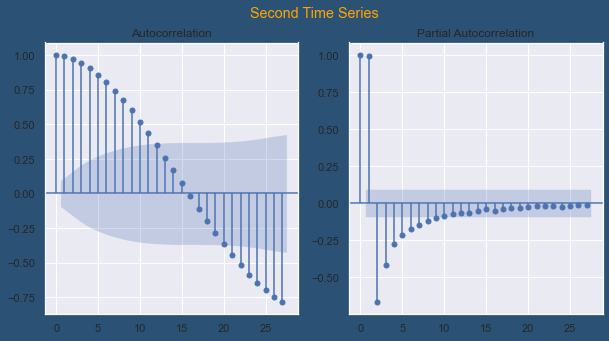

In [604]:
fig = plt.figure(figsize=(10,5),facecolor='#2B5275')
fig.suptitle('Second Time Series', color ='orange')
ax = fig.add_subplot(1,2,1)
plot_acf(df['V2'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(df['V2'], ax=ax)
plt.show()

## Check Differencing

**Result:** Differencing here does not really help to remove increasing heteroscedasity

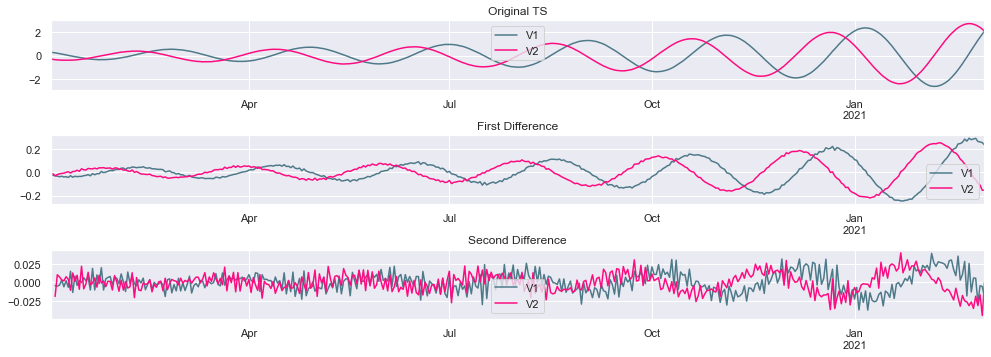

In [605]:
plot_differences(df)

## Dickey_Fuller_Test

Testing Time Series for stationarity 

In [606]:
dickey_fuller(df['V1'])

ADF Statistic: -11.506531
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Reject Ho - Time Series is Stationary


In [607]:
dickey_fuller(df['V2'])

ADF Statistic: -11.927713
p-value: 0.000000
Critical Values:
	1%: -3.447
	5%: -2.869
	10%: -2.571
Reject Ho - Time Series is Stationary


## Check Cointegration

In [608]:
test_cointegration(df['V1'], df['V2'])

t-statistic of unit-root test on residuals: -1.103868
p-value: 0.881312
Critical Values:
	1%: -3.922
	5%: -3.351
	10%: -3.054
Failed to Reject Ho - Time Series are Not Cointegrated


## Granger Causality test



In [609]:
test_result = grangercausalitytests(df[['V1', 'V2']], 2)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=168996.3837, p=0.0000  , df_denom=421, df_num=1
ssr based chi2 test:   chi2=170200.6335, p=0.0000  , df=1
likelihood ratio test: chi2=2542.9348, p=0.0000  , df=1
parameter F test:         F=168996.3837, p=0.0000  , df_denom=421, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=603.7605, p=0.0000  , df_denom=418, df_num=2
ssr based chi2 test:   chi2=1221.9651, p=0.0000  , df=2
likelihood ratio test: chi2=574.4773, p=0.0000  , df=2
parameter F test:         F=603.7605, p=0.0000  , df_denom=418, df_num=2


In [610]:
test_result = grangercausalitytests(df[['V2', 'V1']], 2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=164040.9001, p=0.0000  , df_denom=421, df_num=1
ssr based chi2 test:   chi2=165209.8377, p=0.0000  , df=1
likelihood ratio test: chi2=2530.3478, p=0.0000  , df=1
parameter F test:         F=164040.9001, p=0.0000  , df_denom=421, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=575.0023, p=0.0000  , df_denom=418, df_num=2
ssr based chi2 test:   chi2=1163.7607, p=0.0000  , df=2
likelihood ratio test: chi2=559.2389, p=0.0000  , df=2
parameter F test:         F=575.0023, p=0.0000  , df_denom=418, df_num=2


## Model Building

### Train test Split

In [611]:
df_train = df['1/1/2020':'1/1/2021']
df_test  =  df['1/1/2021':'3/1/2021']

In [612]:
train_len = len(df_train)
test_len = len(df_test)

train_len, test_len

(366, 60)

### Getting lag order

**Results:** BIC suggest lag order 7

In [631]:
model = VAR(df_train)
lag_orders = model.select_order(10)
lag_orders.summary()

,AIC,BIC,FPE,HQIC
0,-0.8452,-0.8235,0.4295,-0.8366
1,-21.18,-21.11,6.344e-10,-21.15
2,-21.69,-21.58,3.818e-10,-21.64
3,-21.90,-21.75,3.083e-10,-21.84
4,-21.95,-21.75,2.940e-10,-21.87
5,-22.02,-21.78,2.747e-10,-21.92
6,-22.11,-21.83,2.495e-10,-22.00
7,-22.17,-21.84*,2.353e-10,-22.04
8,-22.18,-21.81,2.341e-10,-22.03
9,-22.21,-21.80,2.255e-10,-22.05*


In [632]:
lag_order = 7
model_fit = model.fit(maxlags=lag_order)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 18, Mar, 2021
Time:                     15:38:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -21.8341
Nobs:                     359.000    HQIC:                  -22.0296
Log likelihood:           2988.68    FPE:                2.38050e-10
AIC:                     -22.1586    Det(Omega_mle):     2.19338e-10
--------------------------------------------------------------------
Results for equation V1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.023143         0.002092           11.062           0.000
L1.V1         0.153274         0.053517            2.864           0.004
L1.V2         0.007183         0.056525            0.127           0.899
L2.V1         0.144056

## Check Residual

**Results:** The residuals have no autocorrelation, hence the model seems to capture all information.

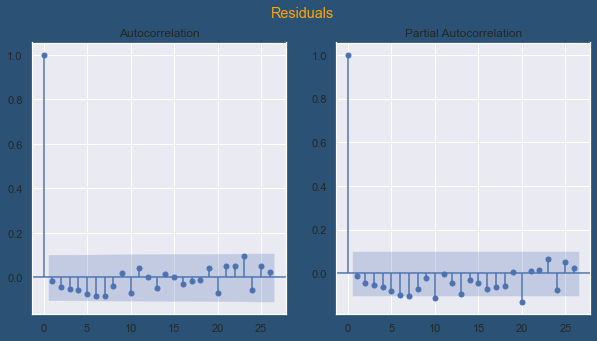

In [633]:
fig = plt.figure(figsize=(10,5),facecolor='#2B5275')
fig.suptitle('Residuals', color ='orange')
ax = fig.add_subplot(1,2,1)
plot_acf(model_fit.resid['V1'], ax=ax)
ax = fig.add_subplot(1,2,2)
plot_pacf(model_fit.resid['V1'], ax=ax)
plt.show()

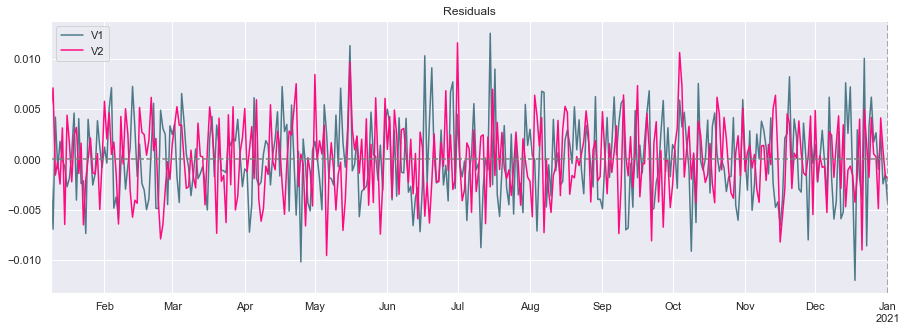

In [634]:
model_fit.resid.plot(figsize=(15,5), color=['#4E7989', '#FD0C81'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('Residuals')
plt.show()

## Durbin-Watson Statistic
We will now check again whether there is any correlation left in the residuals and if so, we will have to increase the order of our model. Values of this statistic varies between 0 & 4. Values closer to 2 mean that there is no significant serial correlation. Values close to 4 indicate strong negative correlation while those closer to 0 imply strong positive correlation.

In [635]:
dw_r = durbin_watson(model_fit.resid)

for col, val in zip(df.columns, dw_r):
    print(col, ':', round(val, 2))

V1 : 2.02
V2 : 2.04


## Forecasts

### Forecast(60 timesteps)

In [636]:
horizon=len(df_test)
prediction = model_fit.forecast(df.values[-lag_order:], steps=horizon)


df_pred = pd.DataFrame(prediction, columns=["V1_forecast", "V2_forecast"], index=df_test.index)
df_prediction =pd.concat([df, df_pred], axis=1)
df_prediction.tail()

,V1,V2,V1_forecast,V2_forecast
2021-02-25,1.030259,2.592554,0.178053,3.716975
2021-02-26,1.298838,2.498765,0.574241,3.705264
2021-02-27,1.563096,2.388439,0.969186,3.655937
2021-02-28,1.821888,2.233862,1.358927,3.569114
2021-03-01,2.060159,2.079783,1.739514,3.445287


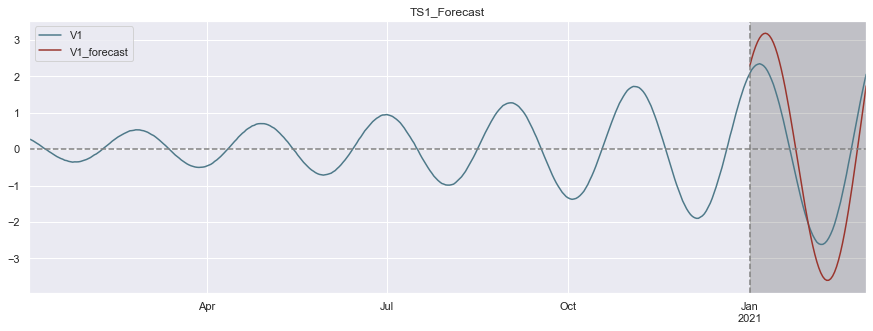

In [637]:
df_prediction[['V1','V1_forecast']].plot(figsize=(15,5), color=['#4E7989', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('TS1_Forecast')
plt.show()

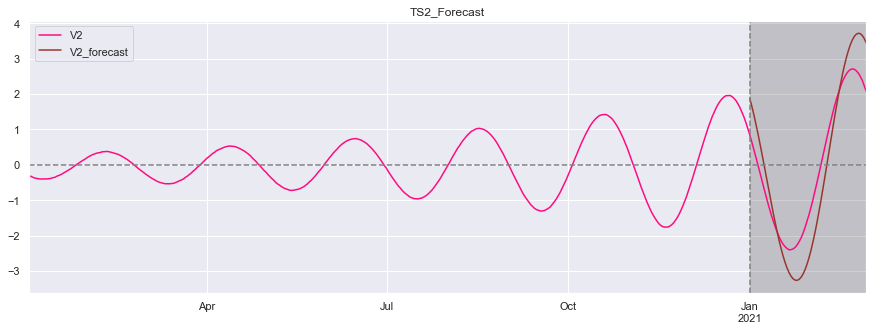

In [638]:
df_prediction[['V2','V2_forecast']].plot(figsize=(15,5), color=['#FD0C81', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('TS2_Forecast')
plt.show()

## Rolling Forecast

In [639]:
rolling_forecast = rolling_forecast_VAR(df,lag_order, train_len, test_len)



In [640]:
rf_V1=[]
rf_V2=[]
for i in range(0,len(rolling_forecast)):
    for j in range(2):
        rf=rolling_forecast[i][0][j]
        if j == 0:
            rf_V1.append(rf)
        else:
            rf_V2.append(rf)

In [641]:
rf = {'TS1_Rolling Forecast':rf_V1, 'TS2_Rolling Forecast':rf_V2}
df_rf = pd.DataFrame(rf, index=df_test.index)
df_horizon =pd.concat([df, df_rf], axis=1)
df_horizon.tail()

,V1,V2,TS1_Rolling Forecast,TS2_Rolling Forecast
2021-02-25,1.030259,2.592554,1.018898,2.594725
2021-02-26,1.298838,2.498765,1.300664,2.501532
2021-02-27,1.563096,2.388439,1.568863,2.384399
2021-02-28,1.821888,2.233862,1.823779,2.242375
2021-03-01,2.060159,2.079783,2.063042,2.071639


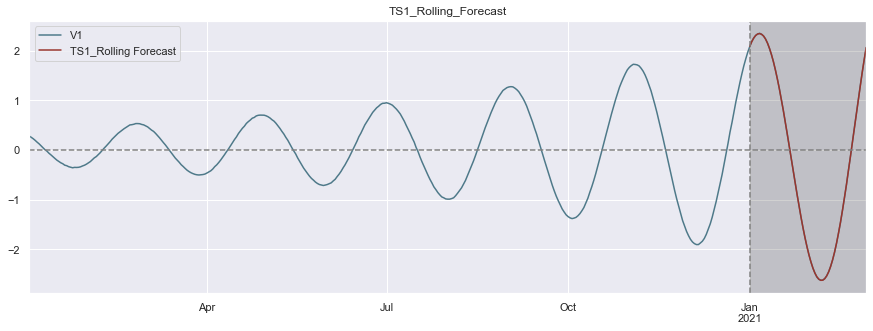

In [642]:
df_horizon[['V1','TS1_Rolling Forecast']].plot(figsize=(15,5), color=['#4E7989', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('TS1_Rolling_Forecast')
plt.show()

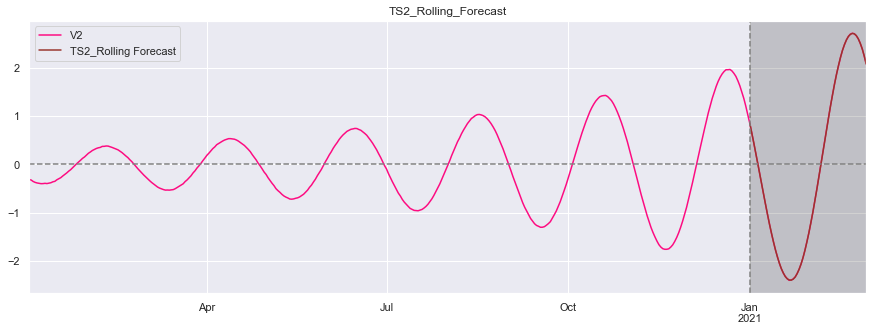

In [643]:
df_horizon[['V2','TS2_Rolling Forecast']].plot(figsize=(15,5), color=['#FD0C81', '#9A352D'])
plt.axhline(0, linestyle='--', color='grey')
plt.axvline('1/1/2021',linestyle='--', color='grey')
plt.axvspan('1/1/2021', '3/1/2021', color='k', alpha=0.2)
plt.title('TS2_Rolling_Forecast')
plt.show()

## Evaluation

### Evaluating Forecast(60 timesteps)

In [644]:
# Extract the predicted and true values of our time series
true = df_test['V1'].values
model_performance = df_prediction['V1_forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the TS1 prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of the TS1 prediction is 0.87


In [645]:
true = df_test['V2'].values
model_performance = df_prediction['V2_forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the TS2 prediction is {}'.format(round(mse, 2)))

The Mean Squared Error of the TS2 prediction is 0.71


### Evaluating Rolling Forecast(1 timestep)

In [646]:
true = df_test['V1'].values
model_performance = df_horizon['TS1_Rolling Forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the TS1 rolling forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of the TS1 rolling forecast is 0.0


In [647]:
true = df_test['V2'].values
model_performance = df_horizon['TS2_Rolling Forecast']['1/1/2021':]


# Compute the mean square error
mse = ((model_performance - true) ** 2).mean()
print('The Mean Squared Error of the TS2 rolling forecast is {}'.format(round(mse, 2)))

The Mean Squared Error of the TS2 rolling forecast is 0.0
